# Indirect Neuron Experiment

April 1, 2022

In "Distinct types of neural reorganization during long-term learning" Zhou et al. 2019 designed a BMI experiment whereby 50% of neurons had to change their "tuning" in order to learn a new mapping. Monkeys were able to adapt to the new BMI decoder quickly and easily. They recorded activity over ~15 days, and found the following interesting results:
* All neurons changed their activity initially
* Over 15 days, however, only neurons directly "perturbed" by the new mapping and readout by the decoder changed their tuning. This corresponded with an improvement in task performance.

I am particularly intrigued by the result that only the 50% of neruons that had to change ethier "tuning" actually changed over the course of ~15 days. Neurons that were read out by the decoder without being "perturbed" remained roughly the same after the first day with the new decoder. Neurons that were recorded but had _no influence on the decoder_ similarly changed on day 1 and remained the same.

In the following code, I try to explore what happens when a learning algorithm like RFLO has a misaligned model of credit assignment. Does it incorrectly update neurons that aren't directly readout by the decoder?

**Tentative Conclusion**

If learning rule has perfect credit assignment matrix, only neurons that are used by the decoder will be updated. Otherwise, "indirect" neuron activity will change just as much as "direct" neuron activity

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("..")

In [3]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories

### Train RNN on four targets using RFLO

In [4]:
trial_duration = 20
n_in=4
frac_on = 0.2

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

# Pretrain

1it [00:00, 26.69it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
eta_in: 0.1
eta_rec: 0.25
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: False
tau_vel: 1
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fe964b32360>
apply_to :  ['w_rec']
online :  False
weight_transport :  True


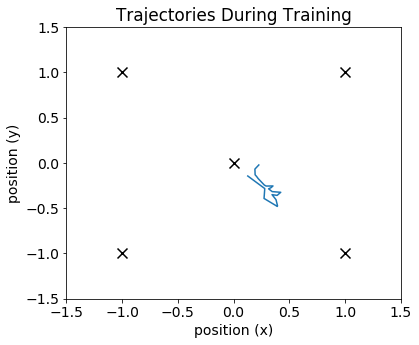

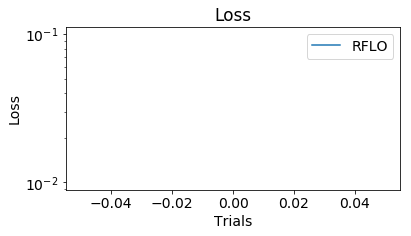

In [52]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.25,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=False, tau_vel = 1, dt_vel = 0.1,
               rng=np.random.RandomState(4))
params.print_params()

# Initialize RNN
net0 = RNN(params)

# initialize simulation
sim0 = Simulation(net0)

# instantiate learning algorithm
# Specify particular matrix/unit to apply algorithm
rflo0 = RFLO(net0,apply_to=['w_rec'],online=False)  
#bptt = BPTT(net0,apply_to=['w_rec','w_out'],online=False) # something strange happening here
rflo0.print_params()


sim0.run_session(n_trials=1, tasks=[task1,task2,task3,task4], learn_alg=[rflo0], probe_types=[], plot=True, plot_freq=20)


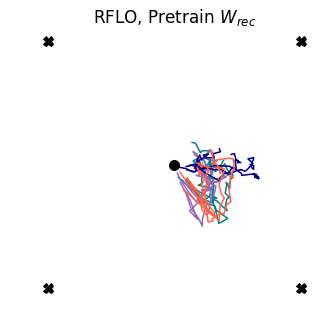

In [53]:
fig = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='RFLO, Pretrain '+r'$W_{rec}$')


# Compare Two Networks

Create two identical networks, and train `w_rec` with unbiased and biased RFLO. In the biased case, matrix `w_m` is the transpose of the pretrained matrix `w_out`

In [54]:
np.random.seed(19680801)

# Initialize RNNs
net1 = RNN(params)
net2 = RNN(params)
net3 = RNN(params)

net1.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec))
net2.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec))
net3.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec))

w_out = np.copy(net1.w_out)
w_m = np.copy(w_out.T)

# select random indices to zero
sub_sample = 30
ind = np.random.choice(np.arange(0,w_out.shape[1],1),sub_sample,replace=False)
#ind1 = ind[:int(sub_sample/2)]
#ind2 = ind[int(sub_sample/2):]
w_out[:,ind] = 0 # set to zero
#w_out[1,ind2] = 0

w_m[ind[:10],:] = 0 # w_m has fewer set to zero

net1.set_weights(w_out=w_out.copy())
net1.set_weights(w_m=w_out.T.copy())

net2.set_weights(w_out=w_out.copy())
net2.set_weights(w_m = w_m.copy())

net3.set_weights(w_out=w_out.copy())
net3.set_weights(w_m=0*w_out.T.copy())

w_out_flat = w_out.flatten()/np.linalg.norm(w_out.flatten())
w_m_flat = w_m.T.flatten()/np.linalg.norm(w_m.T.flatten())
alignment = np.dot(w_out_flat, w_m_flat)
print('alignment:{:.3f}'.format(alignment))

alignment:0.661


25it [00:00, 249.07it/s]

apply_to :  ['w_rec']
online :  False
weight_transport :  True


2000it [00:04, 429.41it/s]


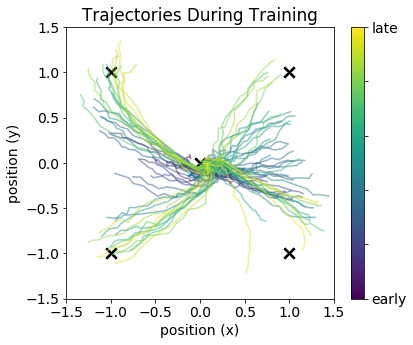

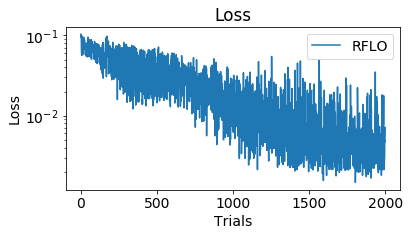

In [55]:
rflo1 = RFLO(net1,apply_to=['w_rec'],online=False)  
rflo1.print_params()

sim1 = Simulation(net1)
sim1.run_session(n_trials=2000, tasks=[task1,task2,task3,task4], learn_alg=[rflo1], probe_types=['h','loss'], plot=True, plot_freq=20)


67it [00:00, 246.48it/s]

apply_to :  ['w_rec']
online :  False
weight_transport :  True


2000it [00:04, 429.74it/s]


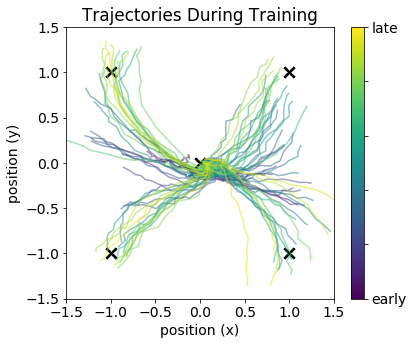

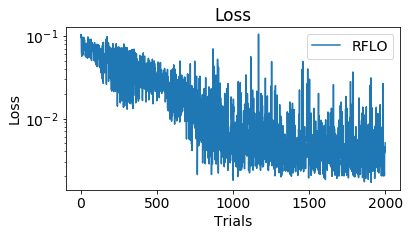

In [56]:
rflo2 = RFLO(net2,apply_to=['w_rec'],online=False) 
rflo2.print_params()

sim2 = Simulation(net2)
sim2.run_session(n_trials=2000, tasks=[task1,task2,task3,task4], learn_alg=[rflo2], probe_types=['h','loss'], plot=True, plot_freq=20)


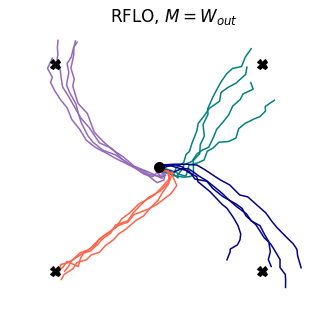

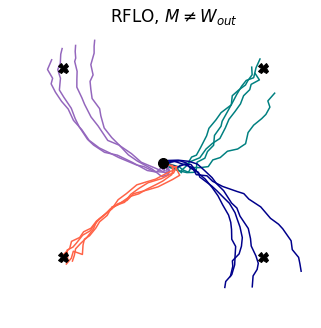

In [57]:
fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4],title='RFLO, '+r'$M=W_{out}$')
fig = plot_trained_trajectories(sim=sim2, tasks=[task1,task2,task3,task4],title='RFLO, '+r'$M \neq W_{out}$')

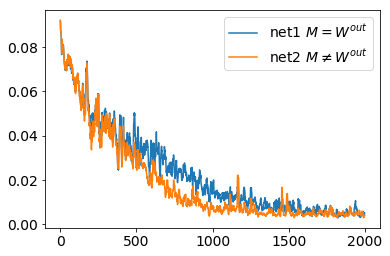

In [58]:
av1 = uniform_filter1d(np.mean(sim1.session_probes['loss'],axis=1),10)
plt.plot(av1,label='net1 '+'$M=W^{out}$')
av2 = uniform_filter1d(np.mean(sim2.session_probes['loss'],axis=1),10)
plt.plot(av2,label='net2 '+r'$M \neq W^{out}$')
plt.legend()
plt.show()

# Compare before and after learning

Note that these are all for the same target/task

1000it [00:01, 947.48it/s]
1000it [00:01, 901.21it/s]
1000it [00:00, 1005.39it/s]


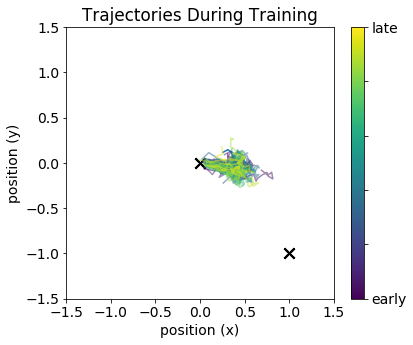

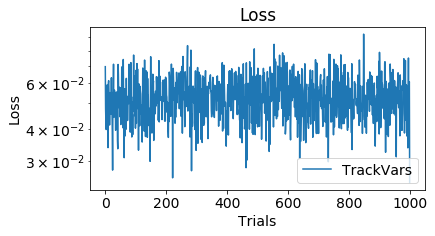

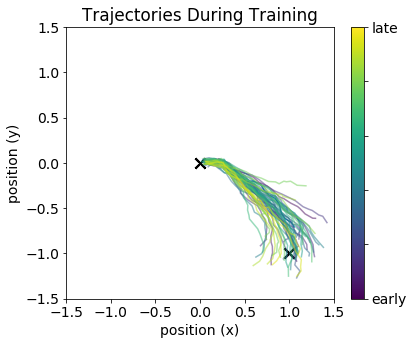

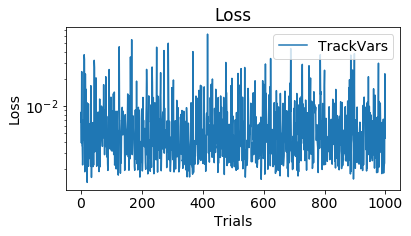

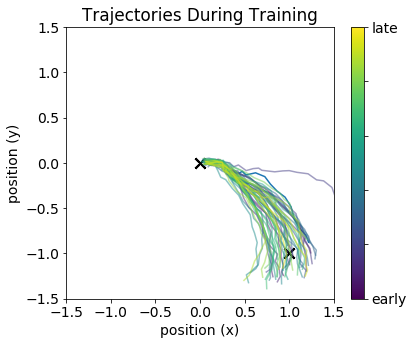

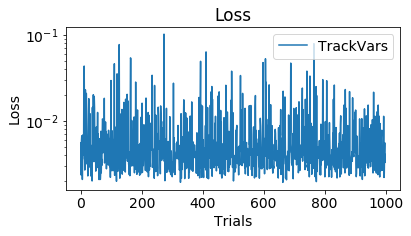

In [59]:
trackvars = TrackVars(net0,apply_to=[]) 
sim0_track = Simulation(net0)
sim0_track.run_session(n_trials=1000, tasks=[task3], learn_alg=[trackvars], probe_types=['h','loss'], plot=True, plot_freq=20)

trackvars = TrackVars(net1,apply_to=[]) 
sim1_track = Simulation(net1)
sim1_track.run_session(n_trials=1000, tasks=[task3], learn_alg=[trackvars], probe_types=['h','loss'], plot=True, plot_freq=20)

trackvars = TrackVars(net2,apply_to=[]) 
sim2_track = Simulation(net2)
sim2_track.run_session(n_trials=1000, tasks=[task3], learn_alg=[trackvars], probe_types=['h','loss'], plot=True, plot_freq=20)


In [60]:
np.asarray(sim0_track.session_probes['h']).squeeze().shape

(1000, 20, 50)

In [61]:

early0 = sim0_track.session_probes['h'] # a list of length # trials. One element of the list is timesteps x neurons x 1
early0 = np.mean(np.asarray(early0).squeeze(),axis=0) # turn list into array, and squeeze. take mean of trials x timesteps x neurons

late1 = sim1_track.session_probes['h']
late1 = np.mean(np.asarray(late1).squeeze(),axis=0)

late2 = sim2_track.session_probes['h']
late2 = np.mean(np.asarray(late2).squeeze(),axis=0)

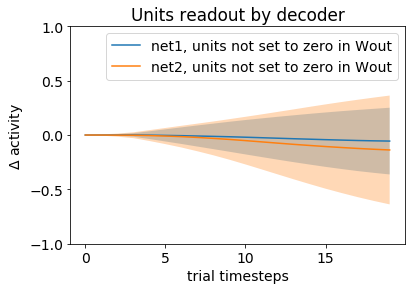

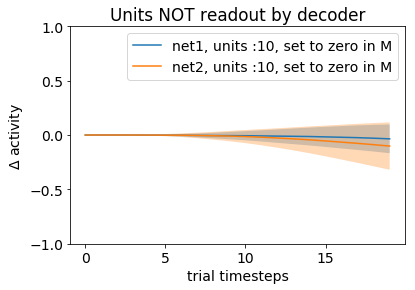

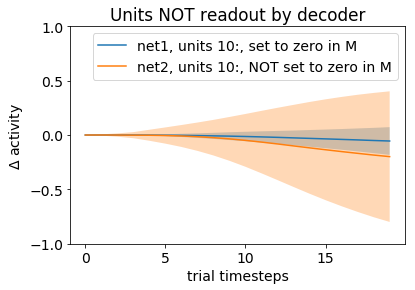

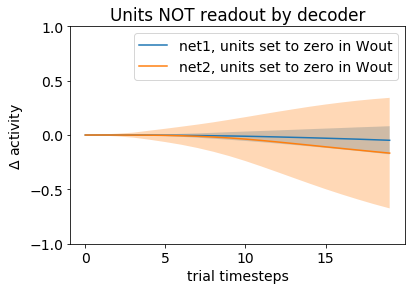

In [62]:
# now compare the average activity of each neuron before and after learning

mn=np.mean(late1[:,~ind] - early0[:,~ind],axis=1)
std = np.std(late1[:,~ind] - early0[:,~ind],axis=1)
plt.plot(mn,label='net1, units not set to zero in Wout')
plt.fill_between(range(len(mn)),mn-std,mn+std,alpha=0.3)

mn=np.mean(late2[:,~ind] - early0[:,~ind],axis=1)
std = np.std(late2[:,~ind] - early0[:,~ind],axis=1)
plt.plot(mn,label='net2, units not set to zero in Wout')
plt.fill_between(range(len(mn)),mn-std,mn+std,alpha=0.3)
plt.legend()
plt.xlabel('trial timesteps')
plt.ylabel(r'$\Delta$'+' activity')
plt.ylim([-1,1])
plt.title('Units readout by decoder')
plt.show()


mn=np.mean(late1[:,ind[:10]] - early0[:,ind[:10]],axis=1)
std = np.std(late1[:,ind[:10]] - early0[:,ind[:10]],axis=1)
plt.plot(mn,label='net1, units :10, set to zero in M')
plt.fill_between(range(len(mn)),mn-std,mn+std,alpha=0.3)

mn=np.mean(late2[:,ind[:10]] - early0[:,ind[:10]],axis=1)
std = np.std(late2[:,ind[:10]] - early0[:,ind[:10]],axis=1)
plt.plot(mn,label='net2, units :10, set to zero in M')
plt.fill_between(range(len(mn)),mn-std,mn+std,alpha=0.3)
plt.legend()
plt.xlabel('trial timesteps')
plt.ylabel(r'$\Delta$'+' activity')
plt.ylim([-1,1])
plt.title('Units NOT readout by decoder')
plt.show()


mn=np.mean(late1[:,ind[10:]] - early0[:,ind[10:]],axis=1)
std = np.std(late1[:,ind[10:]] - early0[:,ind[10:]],axis=1)
plt.plot(mn,label='net1, units 10:, set to zero in M')
plt.fill_between(range(len(mn)),mn-std,mn+std,alpha=0.3)

#plt.plot(np.mean(late1[:,ind[10:]] - early0[:,ind[10:]],axis=1),label='net1, units that shouldnt change')
#plt.show()
mn=np.mean(late2[:,ind[10:]] - early0[:,ind[10:]],axis=1)
std = np.std(late2[:,ind[10:]] - early0[:,ind[10:]],axis=1)
plt.plot(mn,label='net2, units 10:, NOT set to zero in M')
plt.fill_between(range(len(mn)),mn-std,mn+std,alpha=0.3)

plt.legend()
plt.xlabel('trial timesteps')
plt.ylabel(r'$\Delta$'+' activity')
plt.ylim([-1,1])
plt.title('Units NOT readout by decoder')
plt.show()


mn=np.mean(late1[:,ind] - early0[:,ind],axis=1)
std = np.std(late1[:,ind] - early0[:,ind],axis=1)
plt.plot(mn,label='net1, units set to zero in Wout')
plt.fill_between(range(len(mn)),mn-std,mn+std,alpha=0.3)


mn=np.mean(late2[:,ind] - early0[:,ind],axis=1)
std = np.std(late2[:,ind] - early0[:,ind],axis=1)
plt.plot(mn,label='net2, units set to zero in Wout')
plt.fill_between(range(len(mn)),mn-std,mn+std,alpha=0.3)

plt.legend()
plt.xlabel('trial timesteps')
plt.ylabel(r'$\Delta$'+' activity')
plt.ylim([-1,1])
plt.title('Units NOT readout by decoder')
plt.show()

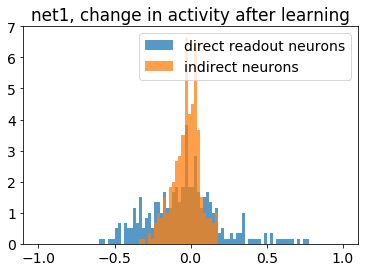

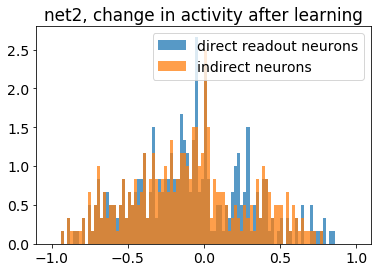

In [63]:

bins=100
start=10
r=(-1,1)
n, _, _ = plt.hist((late1[start:,~ind] - early0[start:,~ind]).ravel(), bins, range=r, density=True, facecolor='C0', rwidth=1, alpha=0.75,label='direct readout neurons')
n, _, _ = plt.hist((late1[start:,ind] - early0[start:,ind]).ravel(), bins=bins, range=r, density=True, facecolor='C1', rwidth=1, alpha=0.75,label='indirect neurons')
plt.legend()
plt.title('net1, change in activity after learning')
plt.show()

n, bins, _ = plt.hist((late2[start:,~ind] - early0[start:,~ind]).ravel(), bins, range=r, density=True, facecolor='C0', rwidth=1, alpha=0.75,label='direct readout neurons')
n, bins, _ = plt.hist((late2[start:,ind] - early0[start:,ind]).ravel(), bins, range=r, density=True, facecolor='C1', rwidth=1, alpha=0.75,label='indirect neurons')
plt.legend()
plt.title('net2, change in activity after learning')
plt.show()

# Compare effects of REINFORCE

30it [00:00, 295.78it/s]

apply_to :  ['w_rec']
online :  False


20000it [00:59, 337.88it/s]


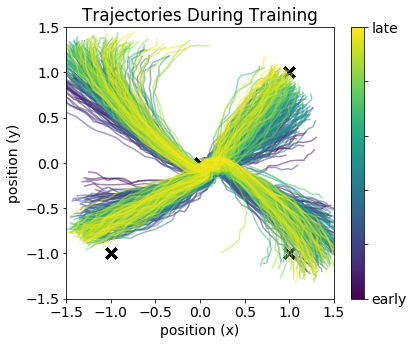

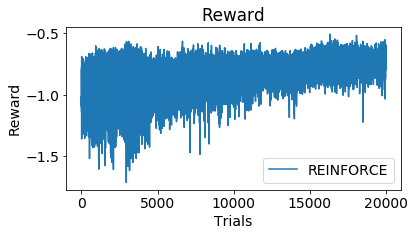

In [67]:
reinforce3 = REINFORCE(net3,apply_to=['w_rec'],online=False,tau_reward=5)  
reinforce3.print_params()

sim3 = Simulation(net3)
sim3.run_session(n_trials=20000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce3], probe_types=['h','reward'], plot=True, plot_freq=20)



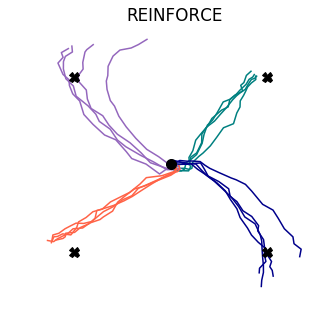

In [68]:
fig = plot_trained_trajectories(sim=sim3, tasks=[task1,task2,task3,task4],title='REINFORCE')


1000it [00:01, 844.49it/s]
1000it [00:01, 653.30it/s]


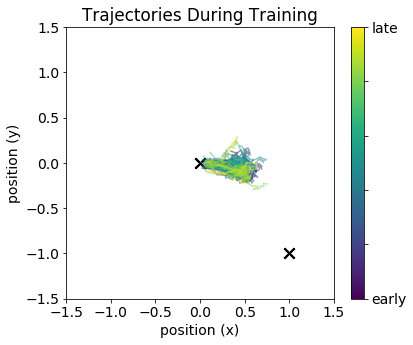

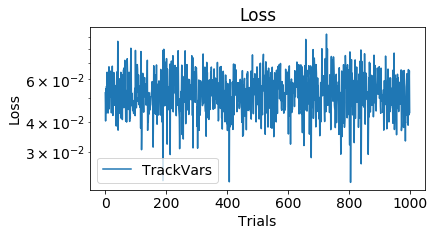

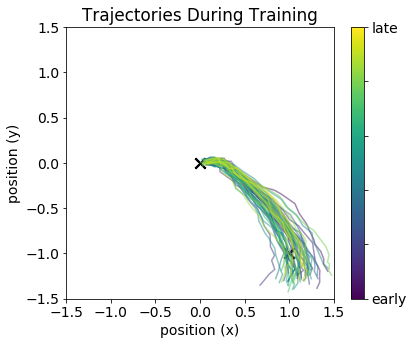

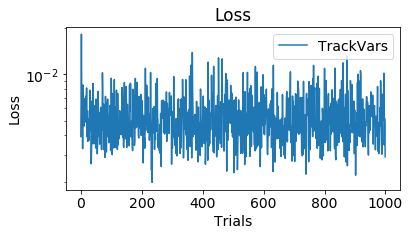

In [77]:
trackvars = TrackVars(net0,apply_to=[]) 
sim0_track = Simulation(net0)
sim0_track.run_session(n_trials=1000, tasks=[task3], learn_alg=[trackvars], probe_types=['h','loss'], plot=True, plot_freq=20)

trackvars = TrackVars(net3,apply_to=[]) 
sim3_track = Simulation(net3)
sim3_track.run_session(n_trials=1000, tasks=[task3], learn_alg=[trackvars], probe_types=['h','loss'], plot=True, plot_freq=20)


early0 = sim0_track.session_probes['h'] # a list of length # trials. One element of the list is timesteps x neurons x 1
early0 = np.mean(np.asarray(early0).squeeze(),axis=0) # turn list into array, and squeeze. take mean of trials x timesteps x neurons

late3 = sim3_track.session_probes['h']
late3 = np.mean(np.asarray(late3).squeeze(),axis=0)

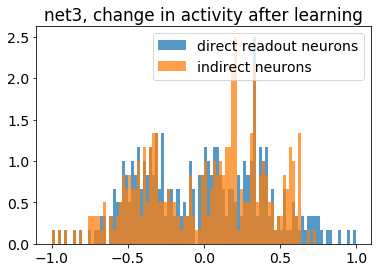

In [78]:
bins=100
start=10
r=(-1,1)
n, _, _ = plt.hist((late3[start:,~ind] - early0[start:,~ind]).ravel(), bins, range=r, density=True, facecolor='C0', rwidth=1, alpha=0.75,label='direct readout neurons')
n, _, _ = plt.hist((late3[start:,ind] - early0[start:,ind]).ravel(), bins=bins, range=r, density=True, facecolor='C1', rwidth=1, alpha=0.75,label='indirect neurons')
plt.legend()
plt.title('net3, change in activity after learning')
plt.show()

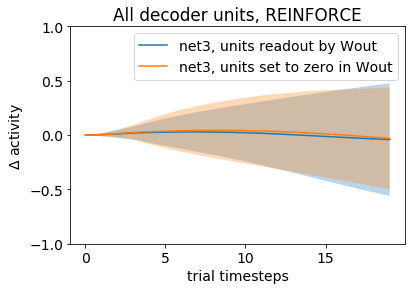

In [79]:
mn=np.mean(late3[:,~ind] - early0[:,~ind],axis=1)
std = np.std(late3[:,~ind] - early0[:,~ind],axis=1)
plt.plot(mn,label='net3, units readout by Wout')
plt.fill_between(range(len(mn)),mn-std,mn+std,alpha=0.3)


mn=np.mean(late3[:,ind] - early0[:,ind],axis=1)
std = np.std(late3[:,ind] - early0[:,ind],axis=1)
plt.plot(mn,label='net3, units set to zero in Wout')
plt.fill_between(range(len(mn)),mn-std,mn+std,alpha=0.3)


plt.legend()
plt.xlabel('trial timesteps')
plt.ylabel(r'$\Delta$'+' activity')
plt.ylim([-1,1])
plt.title('All decoder units, REINFORCE')
plt.show()